In [155]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import sys
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="0" #! specify gpu here

# import matplotlib
import matplotlib.pyplot as plt

import datetime
import seaborn as sns
import json
import warnings
from pathlib import Path
import random
import base64
from io import BytesIO
import cv2
import vision_pipeline.obb
import imagesize
import skimage
# from scipy import ndimage
import natsort
from PIL import Image as PILImage
from PIL import ImageDraw, ImageFilter
import numpy as np
from tqdm import tqdm
from shapely.geometry import Polygon
from rich import print
from types import SimpleNamespace
import pickle
import imutils

# ros package
from context_action_framework.types import Detection, Label, Module, Camera
from sensor_msgs.msg import Image, CameraInfo # CameraInfo needed for pickle
# local imports
from vision_pipeline.helpers import Struct, make_valid_poly, img_to_camera_coords, scale_img, add_angles, load_depth_data_from_filename, robust_minimum

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


{
    'dist': [
        [
            0.17552520861910742,
            -0.5466453981464119,
            0.0023151321363011914,
            -0.001285243001696176,
            0.45479571742319025
        ]
    ],
    'mean_error': 0.030174639017348272,
    'mtx': [
        [911.4103433784628, 0.0, 653.5337103156913],
        [0.0, 910.7896219344885, 339.3534393997042],
        [0.0, 0.0, 1.0]
    ],
    'rms': 0.2583445215980058
}

camera_mtx.shape
(3, 3)

[[911.41034338   0.         653.53371032]
 [  0.         910.78962193 339.3534394 ]
 [  0.           0.           1.        ]]

camera_dist.shape
(1, 5)

[[ 0.17552521 -0.5466454   0.00231513 -0.00128524  0.45479572]]

depth_img 0 291

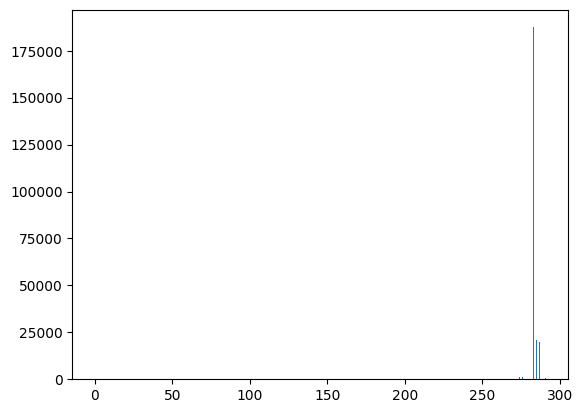

colour_img.shape
(720, 1280, 3)

depth_img.shape
(720, 1280)

depth_img 0.0 0.291

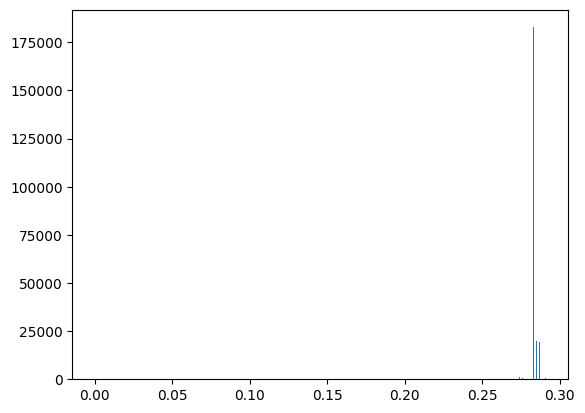

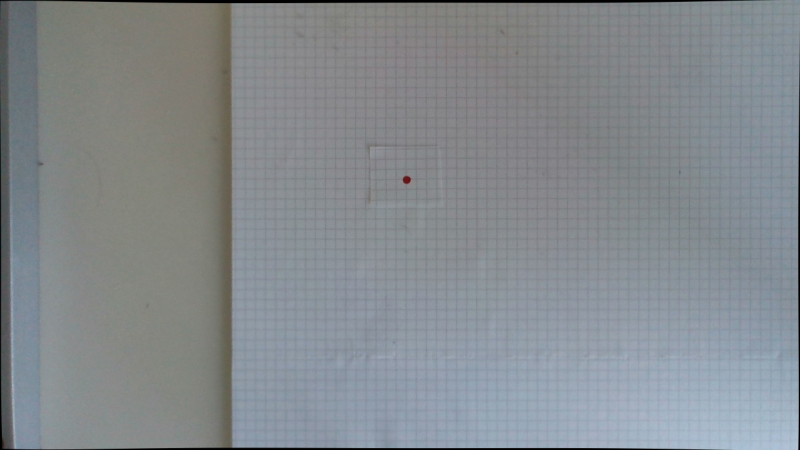

In [156]:
base_path = Path("~/vision_pipeline/saves/2024-07-30_12:30:18_realsense_red_dot").expanduser()
img_path = Path("0001.jpg")

depth_rescaling_factor = 1/1000

colour_img, depth_vis_img, depth_img, camera_info = load_depth_data_from_filename(img_path.stem, base_path, 1)

camera_calib_path = Path("~/vision_pipeline/saves/2024-07-30_09:47:16_realsense_calibration/camera_calibration.json").expanduser()
camera_calib = None
with open(camera_calib_path) as f:
    camera_calib = json.load(f)
    print(camera_calib)
    camera_mtx = np.array(camera_calib["mtx"])
    camera_dist = np.array(camera_calib["dist"])
    print("camera_mtx.shape", camera_mtx.shape)
    print(camera_mtx)
    print("camera_dist.shape", camera_dist.shape)
    print(camera_dist)





# d_img - np.min(d_img))/216).astype(int)
# depth_img = d_img
# c = (200*(d_img - np.min(d_img))/216).astype(int)+55



print("depth_img", np.min(depth_img), np.max(depth_img))
plt.hist(depth_img.flatten(), bins=1000)
plt.show()

h, w = colour_img.shape[:2]
newcameramtx, roi = cv2.getOptimalNewCameraMatrix(camera_mtx, camera_dist, (w, h), 1, (w, h))
colour_img = cv2.undistort(colour_img, camera_mtx, camera_dist, None, newcameramtx)
depth_img = cv2.undistort(depth_img, camera_mtx, camera_dist, None, newcameramtx)

# min_val = np.min(depth_img)
# max_val = np.max(depth_img)

# # Normalize the depth values to the range 0-255
# normalized_depth = cv2.normalize(depth_img, None, 0, 255, cv2.NORM_MINMAX)
# normalized_depth = np.uint8(normalized_depth)


# normalized_depth_undistort = cv2.undistort(normalized_depth, camera_mtx, camera_dist, None, newcameramtx)


# # Undo the normalization
# # Convert the 8-bit values back to the original range
# restored_depth_image = normalized_depth_undistort * (max_val - min_val) / 255 + min_val

# # Ensure the restored depth image has the same type as the original depth image
# restored_depth_image = restored_depth_image.astype(depth_img.dtype)

# depth_img = restored_depth_image

#! what if we do the rescaling after the undistort?
depth_img = depth_img * depth_rescaling_factor


print("colour_img.shape", colour_img.shape)
print("depth_img.shape", depth_img.shape)

              
print("depth_img", np.min(depth_img), np.max(depth_img))
plt.hist(depth_img.flatten(), bins=1000)
plt.show()
                        

display(PILImage.fromarray(scale_img(cv2.cvtColor(colour_img, cv2.COLOR_BGR2RGB))))


dot_coord_px [651 289]

dot_contour [[[651 287]]

 [[651 288]]

 [[650 289]]

 [[651 290]]

 [[651 291]]

 [[652 291]]

 [[653 290]]

 [[653 288]]

 [[652 288]]]

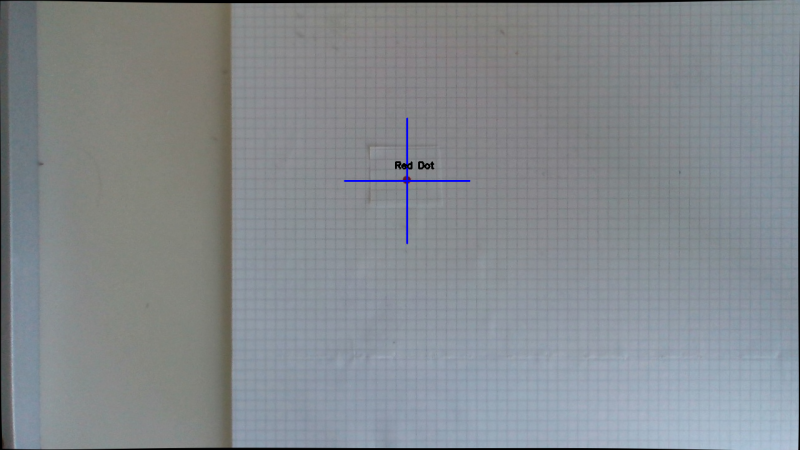

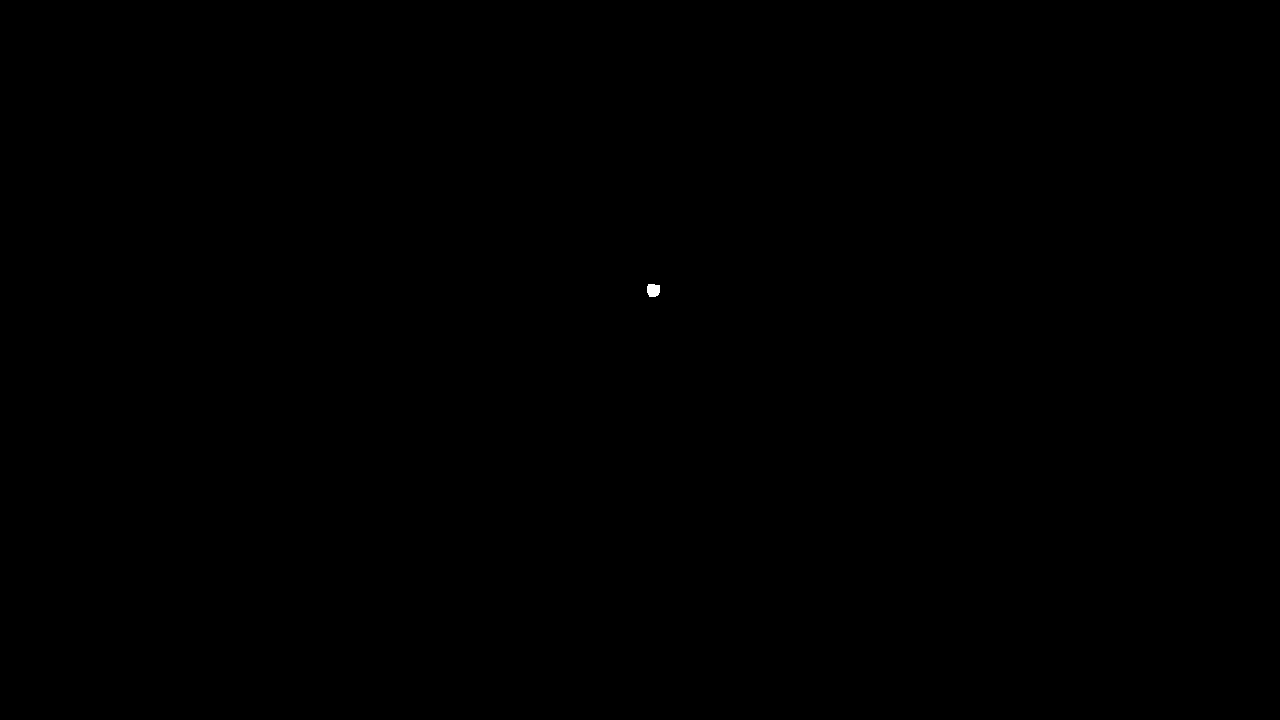

In [157]:
painted_img = colour_img.copy()

# Convert the image to the HSV color space
hsv_image = cv2.cvtColor(painted_img, cv2.COLOR_BGR2HSV)

# Define the red color range in HSV
# These values might need adjustment depending on the exact shade of red
lower_red = np.array([0, 100, 100])
upper_red = np.array([10, 255, 255])

# Create a mask for the red color
mask = cv2.inRange(hsv_image, lower_red, upper_red)

# Find contours in the mask
contours, _ = cv2.findContours(mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

if len(contours) == 0:
    print("error! no dot!")

dot_contour = None
dot_coord_px = None
# Draw the contours and locate the red dot
for contour in contours:
    # Get the moments to calculate the center of the contour
    M = cv2.moments(contour)
    if M['m00'] != 0:
        cX = int(M['m10'] / M['m00'])
        cY = int(M['m01'] / M['m00'])
        dot_coord_px = np.array([cX, cY])
        print("dot_coord_px", dot_coord_px)
        
        dot_contour = contour
        print("dot_contour", dot_contour)
        # Draw the contour and center of the red dot
        # cv2.drawContours(colour_img, [contour], -1, (0, 255, 0), 2)
        # cv2.circle(colour_img, (cX, cY), 7, (255, 0, 0), -1)
        cross_size = 100
        cv2.line(painted_img, (cX - cross_size, cY), (cX + cross_size, cY), (255, 0, 0), 2)
        cv2.line(painted_img, (cX, cY - cross_size), (cX, cY + cross_size), (255, 0, 0), 2)

        cv2.putText(painted_img, "Red Dot", (cX - 20, cY - 20), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0), 2)

# mask = np.zeros(painted_img.shape[:2])
# print("mask", mask.shape)
# mask = np.array(cv2.drawContours(mask, [dot_contour], 0, (1), thickness=cv2.FILLED), dtype=np.uint8)
# print("mask", mask.shape)

kernel = np.ones((3, 3), np.uint8)
mask = cv2.dilate(mask, kernel, iterations=3)

display(PILImage.fromarray(scale_img(cv2.cvtColor(painted_img, cv2.COLOR_BGR2RGB))))
display(PILImage.fromarray(cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)))

# not working:
# points_for_undistort = np.array([[dot_coord_px]])
# print("points_for_undistort.shape", points_for_undistort.shape)
# xn_u = cv2.undistortPoints(points_for_undistort, camera_mtx, camera_dist, None, None)[:, 0].T
# print("xn_u", xn_u)

depth_robust_min 0.281

depth_min_nonzero 0.001

depth_max 0.291

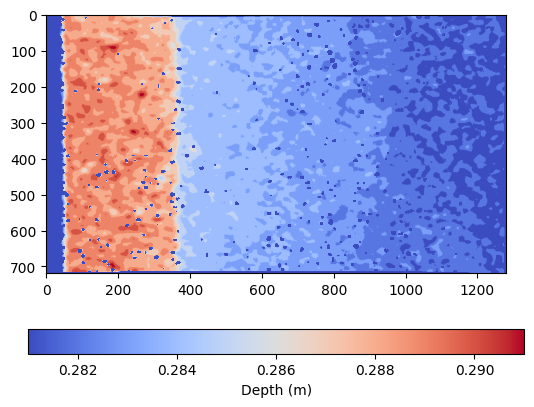

depth_robust_min 0.28300000000000003

depth_min_nonzero 0.28300000000000003

depth_max 0.28400000000000003

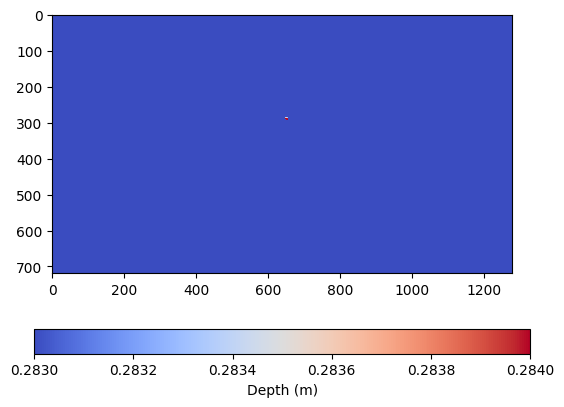

In [163]:
depth_masked = cv2.bitwise_and(depth_img, depth_img, mask=mask)
depth_masked_np = np.ma.masked_equal(depth_masked, 0.0, copy=False)
compressed_depth = depth_masked_np.compressed()
depth_robust_min = robust_minimum(compressed_depth)
# print("depth_robust_min", depth_robust_min)
# print("min", depth_masked_np.min())

def plot_depth(depth_img):
    depth_min_nonzero = np.min(depth_img[np.nonzero(depth_img)])
    
    # set robust_minimum with trim of .5% for a bit more leeway
    depth_robust_min = robust_minimum(depth_img[np.nonzero(depth_img)], 0.05) 

    depth_max = np.max(depth_img)
    print("depth_robust_min", depth_robust_min)
    print("depth_min_nonzero", depth_min_nonzero)
    print("depth_max", depth_max)

    plt_im = plt.imshow(depth_img, vmin=depth_robust_min, vmax=depth_max, cmap='coolwarm')
    plt.colorbar(plt_im, label="Depth (m)", orientation='horizontal')
    plt.show()

plot_depth(depth_img)
plot_depth(depth_masked)


In [159]:
img_to_camera_coords(dot_coord_px, depth_robust_min, camera_info)

array([-0.00123557, -0.01539978,  0.28299999])